# A note on Causal Mediation Analysis on Navy CHARM

N=LV3= neutrophil assoc. ISGs

αβ=LV10=type I IFN ISGs 

γ=LV6=type II IFN ISGs

O=LV5=other ISG


In [1]:
library('mediation')
library('LSD')
library('lme4')
library('tidyverse')

setwd('/mnt/home/zzhang/ceph/jemm')
theme_set(theme_bw(base_size = 12))
options(repr.plot.width=9, repr.plot.height=9)

myTheme = ggplot2::theme(
                legend.text = ggplot2::element_text(size = 13),
                plot.title = ggplot2::element_text(size=13, face="bold"),
                axis.title.y = ggplot2::element_text(size=13),
                axis.title.x = ggplot2::element_text(size=13),
                axis.text.y = ggplot2::element_text(size=13),
                axis.text.x = ggplot2::element_text(size=13),
                legend.background = ggplot2::element_rect(fill = "transparent", colour = "transparent"))

Loading required package: MASS

Loading required package: Matrix

Loading required package: mvtnorm

Loading required package: sandwich

mediation: Causal Mediation Analysis
Version: 4.5.0


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ dplyr::select() masks MASS::select()
✖ tidyr::unpack() masks Matrix::unpack()



# Read data and PCA

In [2]:
# read in data
symp_df = read.table('data-V9/mediation_analysis/first_mid.forCMA.withRaceEthnicityDummies.txt', header=T, sep="\t")
symp_df[,'viral_load'] = 40 - symp_df['CTavg']

SIGNIF_CUTOFF = 1
N_SIMS = 2000
#N_PCS = 5

tot_res = NULL

In [3]:
# re-define symptomatic
sub.symps = c('abd', 'chill', 'cough', 'diarr', 'fatigue', 'fvr', 'headache',
    'msk', 'nv', 'rn_nose', 'sob', 'subj_fvr', 'taste', 'throat')
# DO NOT RUN - IS IDENTICAL
#plot(as.numeric(apply(symp_df[, sub.symps], 1, sum)), symp_df$num_symps)
#symp_df['num_symps'] = as.numeric(apply(symp_df[, sub.symps], 1, sum))

# Utils funcs

In [4]:
make_plot_tibble = function(model, med_outs){
  med_out = med_outs[[model]]
  med_var = strsplit(this$model[1], "\\.")[[1]] %>% tail(n=1)
  tibble(mediator = med_var,
   effect = c("ACME", "ADE", "Total effect", "Prop. Mediated") ,
   estimate = c(med_out$d0, med_out$z0, med_out$tau.coef, med_out$n.avg),
   conf_lower = c(med_out$d0.ci[1], med_out$z0.ci[1], med_out$tau.ci[1], med_out$n.avg.ci[1]),
   conf_upper = c(med_out$d0.ci[2], med_out$z0.ci[2], med_out$tau.ci[2], med_out$n.avg.ci[2]))
}

vis_med_out = function(this, med_outs) {
    tibble(
        variable=this$model,
    ) %>% mutate(results = map(this$model, make_plot_tibble, med_outs)) %>%
    unnest(cols=c(results)) %>% 
    ggplot(aes(variable, estimate, ymin = conf_lower, ymax = conf_upper)) + 
      facet_wrap(~ effect, scales = "free_x") + 
      geom_pointrange() + 
      coord_flip() + 
      labs(y = "Estimate", x = "") +
      geom_hline(yintercept=0, linetype='dashed', color="black") + myTheme
}

rbind.tibble.to_res = function(tibble_res, tot_res) {

    this = tibble_res %>% select(-data) %>%
      unnest(c(results)) 
    pvals = this %>% 
      pivot_wider(mediator, names_from="effect", values_from="pvals") %>%
      filter(ACME<SIGNIF_CUTOFF)

    est = this %>% 
      pivot_wider(mediator, names_from="effect", values_from="estimate") %>%
      filter(mediator %in% pvals$mediator)

    model = pvals$mediator
    add = data.frame(
       model=model,
       acme=est$ACME,
       acme.p=pvals$ACME,
       prop = est$'Prop. Mediated',
       prop.p = pvals$'Prop. Mediated'
    )
    print(add)
    tot_res = rbind.data.frame(tot_res, add, stringsAsFactors=F)
    tot_res
}

# 1. Mediation to viral load [BASELINE --> INITIAL INFECT (w/ or w/o RNA-seq)]

In [5]:
first_data = symp_df[symp_df$final=="First", ]
mid_data = symp_df[symp_df$final=="Mid", ]

#mediators = paste('PC', seq(1,N_PCS), sep='')

In [6]:
mediators = c(
    'base_ISG_LV3',
    'base_ISG_LV5',
    'base_ISG_LV6',
    'base_ISG_LV10'
)

In [7]:
datasets = list(first=first_data[!is.na(first_data$base_ISG_LV3_prj),])
datasets$first %>% distinct(pid, Sex) %>% count(Sex)

Sex,n
<chr>,<int>
F,25
M,193


In [8]:
#print(mediators)

outcome = c('viral_load')
treatment = c('is_female')
covariates = c('Race + Ethnicity')

set.seed(123)
x.ct = mediations(datasets, treatment, mediators, outcome,
        covariates=covariates,
        families=c('gaussian', 'gaussian'),
        conf.level=0.9,
        #sims=N_SIMS,
        sims=100,
        boots=T
)

res.ct = NULL
for(i in 1:length(x.ct)) {
        this = summary(x.ct[[names(x.ct)[i]]])
        res.ct = rbind.data.frame(res.ct,
                list(
                        model = names(x.ct)[i],
                        acme = this$d.avg,
                        acme.p = this$d.avg.p,
                        prop = this$n0,
                        prop.p = this$n0.p
                ),
        stringsAsFactors=F
        )
}
#res.ct$acme.fdr = p.adjust(res.ct$acme.p, method='fdr')
print(res.ct[res.ct$acme.p<SIGNIF_CUTOFF,])
tot_res = rbind.data.frame(tot_res, res.ct[res.ct$acme.p<SIGNIF_CUTOFF,], stringsAsFactors=F)

                               model        acme acme.p        prop prop.p
1  viral_load.is_female.base_ISG_LV3 -0.21823526   0.74 0.082666717   0.74
2  viral_load.is_female.base_ISG_LV5 -0.02185973   0.84 0.007073958   0.82
3  viral_load.is_female.base_ISG_LV6 -0.60082188   0.04 0.182930684   0.18
4 viral_load.is_female.base_ISG_LV10 -0.30815731   0.28 0.114338066   0.36


In [9]:
# vis
res.ct

model,acme,acme.p,prop,prop.p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
viral_load.is_female.base_ISG_LV3,-0.21823526,0.74,0.082666717,0.74
viral_load.is_female.base_ISG_LV5,-0.02185973,0.84,0.007073958,0.82
viral_load.is_female.base_ISG_LV6,-0.60082188,0.04,0.182930684,0.18
viral_load.is_female.base_ISG_LV10,-0.30815731,0.28,0.114338066,0.36


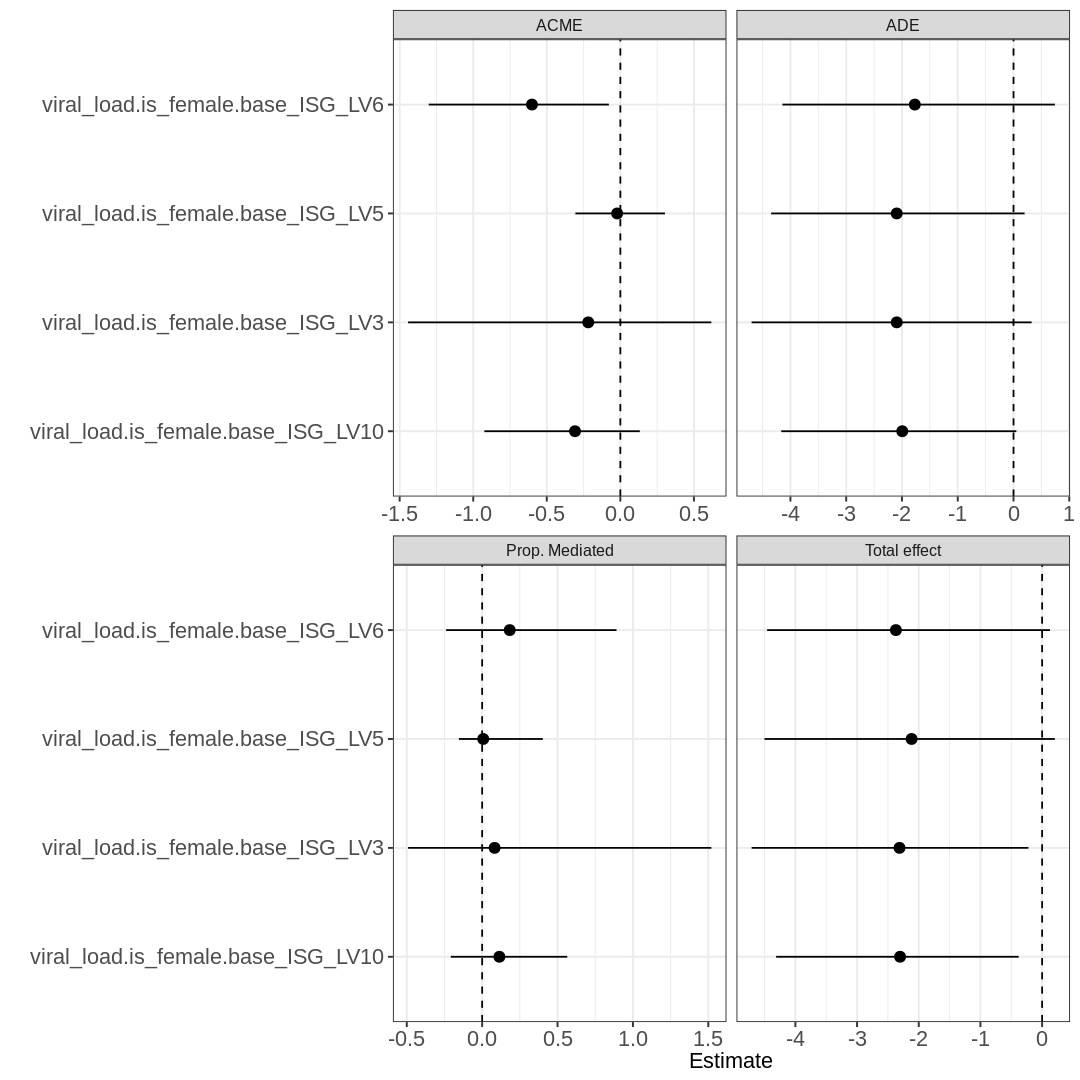

In [10]:
# vis for ct
this = res.ct[res.ct$acme.p<SIGNIF_CUTOFF,]
if(nrow(this)>0) vis_med_out(res.ct, x.ct)

# 2. Mediation for Number of Symptoms [BASELINE TO INITIAL PCR positive (w/ or w/o RNA-seq]

In [11]:
first_data[(!is.na(first_data$base_ISG_LV3_prj)) & (!is.na(first_data$num_symps)),] %>% distinct(pid, Sex) %>% count(Sex)


Sex,n
<chr>,<int>
F,25
M,193


In [12]:
# for Poisson regression we select only count with >30 samps
table(first_data$Race)


                    AI_AN        Asian        Black Hawaiian_OPI Multi_racial 
          51           13           30          150            6           37 
       Other        White 
          23          832 

In [13]:
poisson_med_func <- function(data, med_var, n_sim = N_SIMS, ...) { 
  out_fit <- glm(num_symps ~ value + is_female + Race_White + Race_Black + Race_Asian + Race_Multi_racial + Ethnicity_Hispanic, data = data, family='poisson')
  med_fit <- lm(value ~ is_female + Race_White + Race_Black + Race_Asian + Race_Multi_racial + Ethnicity_Hispanic, data = data)
  med_out <- mediate(med_fit, out_fit, sims = n_sim,
                     treat = "is_female",
                     mediator = "value",
                     covariates = c('Race_White + Race_Black + Race_Asian + Race_Multi_racial + Ethnicity_Hispanic'),
                     conf.level=0.9,
                     boots=T,
                     ...)
  #if(med_out$d0.p < 0.05) {
  #    med_sens <- medsens(med_out, rho.by=0.1, eps=0.01, sim=100)
  #    print(paste('Num_Symps', 'is_female', med_var, sep="."))  
  #    print(summary(med_sens))
  #    print('----------')  
  #    par(mfrow=c(2,2))
  #    plot(med_sens, main=paste('Num_Symps', 'is_female', med_var, sep="."), sens.par="rho")
  #    plot(med_sens, sens.par="R2", sign.prod = "positive")
  #}
  tibble(mediator = paste('Num_Symps', 'is_female', med_var, sep="."),
       effect = c("ACME", "ADE", "Total effect", "Prop. Mediated") ,
       estimate = c(med_out$d0, med_out$z0, med_out$tau.coef, med_out$n.avg),
       conf_lower = c(med_out$d0.ci[1], med_out$z0.ci[1], med_out$tau.ci[1], med_out$n.avg.ci[1]),
       conf_upper = c(med_out$d0.ci[2], med_out$z0.ci[2], med_out$tau.ci[2], med_out$n.avg.ci[2]),
       pvals = c(med_out$d0.p, med_out$z0.p, med_out$tau.p, med_out$n.avg.p)
    )
}

# ---------- #
set.seed(123)
pois_med_res <- first_data %>%
  pivot_longer(all_of(mediators), names_to = "variable", values_to = "value") %>% 
  group_by(variable) %>% 
  nest() %>%
  mutate(results = map(data, poisson_med_func, variable, n_sim = N_SIMS))

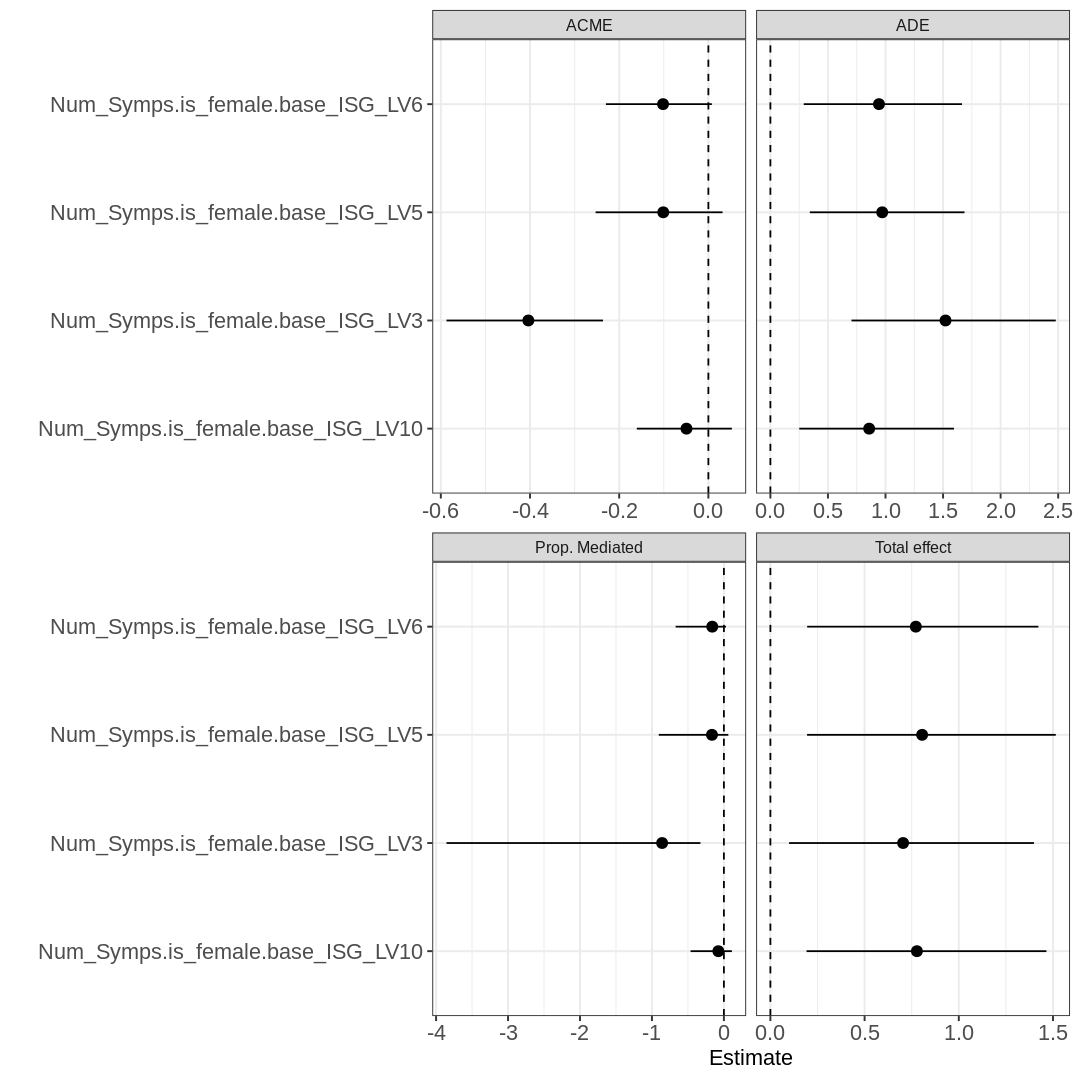

In [14]:
pois_med_res %>% select(-data) %>%
  unnest(c(results)) %>% 
  ggplot(aes(mediator, estimate, ymin = conf_lower, ymax = conf_upper)) + 
  facet_wrap(~ effect, scales = "free_x") + 
  geom_pointrange() + 
  coord_flip() + 
  labs(y = "Estimate", x = "") + 
  geom_hline(yintercept=0, linetype='dashed', color="black") + myTheme

In [15]:
this = pois_med_res %>% select(-data) %>%
  unnest(c(results)) 
pvals = this %>% 
  pivot_wider(mediator, names_from="effect", values_from="pvals") %>%
  filter(ACME<SIGNIF_CUTOFF)

est = this %>% 
  pivot_wider(mediator, names_from="effect", values_from="estimate") %>%
  filter(mediator %in% pvals$mediator)

model = pvals$mediator
add = data.frame(
   model=model,
   acme=est$ACME,
   acme.p=pvals$ACME,
   prop = est$'Prop. Mediated',
   prop.p = pvals$'Prop. Mediated'
)
tot_res = rbind.data.frame(tot_res, add, stringsAsFactors=F)

In [16]:
add

model,acme,acme.p,prop,prop.p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Num_Symps.is_female.base_ISG_LV3,-0.40370368,0.000,-0.85845055,0.038
Num_Symps.is_female.base_ISG_LV5,-0.10120506,0.212,-0.16593692,0.232
Num_Symps.is_female.base_ISG_LV6,-0.10165457,0.136,-0.16193591,0.157
Num_Symps.is_female.base_ISG_LV10,-0.04912645,0.401,-0.07733171,0.414


# 3. Mediation for Infection ISGs [BASELINE --> INFECT RNA-seq]

In [17]:
symp_df[(!is.na(symp_df[,'base_ISG_LV3_prj'])) & (!is.na(symp_df[,'ISG_LV3_prj'])),] %>% distinct(pid, Sex) %>% count(Sex)


Sex,n
<chr>,<int>
F,17
M,163


                                model         acme acme.p         prop prop.p
1  ISG_LV3_prj.is_female.base_ISG_LV3  0.120623568  0.000  0.651736886  0.010
2  ISG_LV3_prj.is_female.base_ISG_LV5 -0.001054129  0.943 -0.003686592  0.945
3  ISG_LV3_prj.is_female.base_ISG_LV6 -0.007889359  0.658 -0.040613931  0.665
4 ISG_LV3_prj.is_female.base_ISG_LV10 -0.027769290  0.230 -0.143810348  0.239


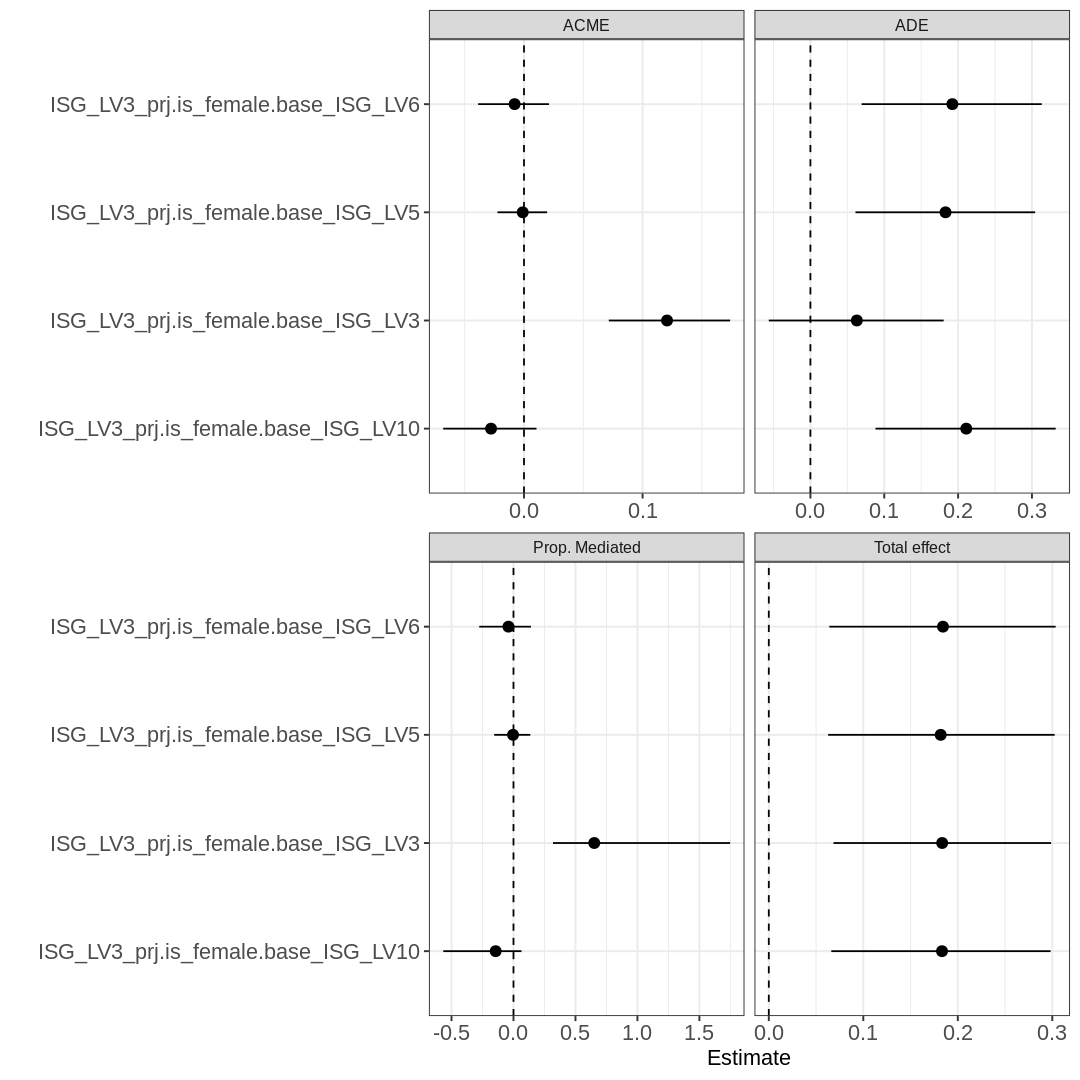

                                model         acme acme.p         prop prop.p
1  ISG_LV5_prj.is_female.base_ISG_LV3 -0.003558224  0.763  0.001409944  0.998
2  ISG_LV5_prj.is_female.base_ISG_LV5 -0.034403763  0.001 -0.392893874  0.925
3  ISG_LV5_prj.is_female.base_ISG_LV6 -0.008775866  0.201 -0.037443635  0.946
4 ISG_LV5_prj.is_female.base_ISG_LV10 -0.026475070  0.001 -0.401595391  0.911


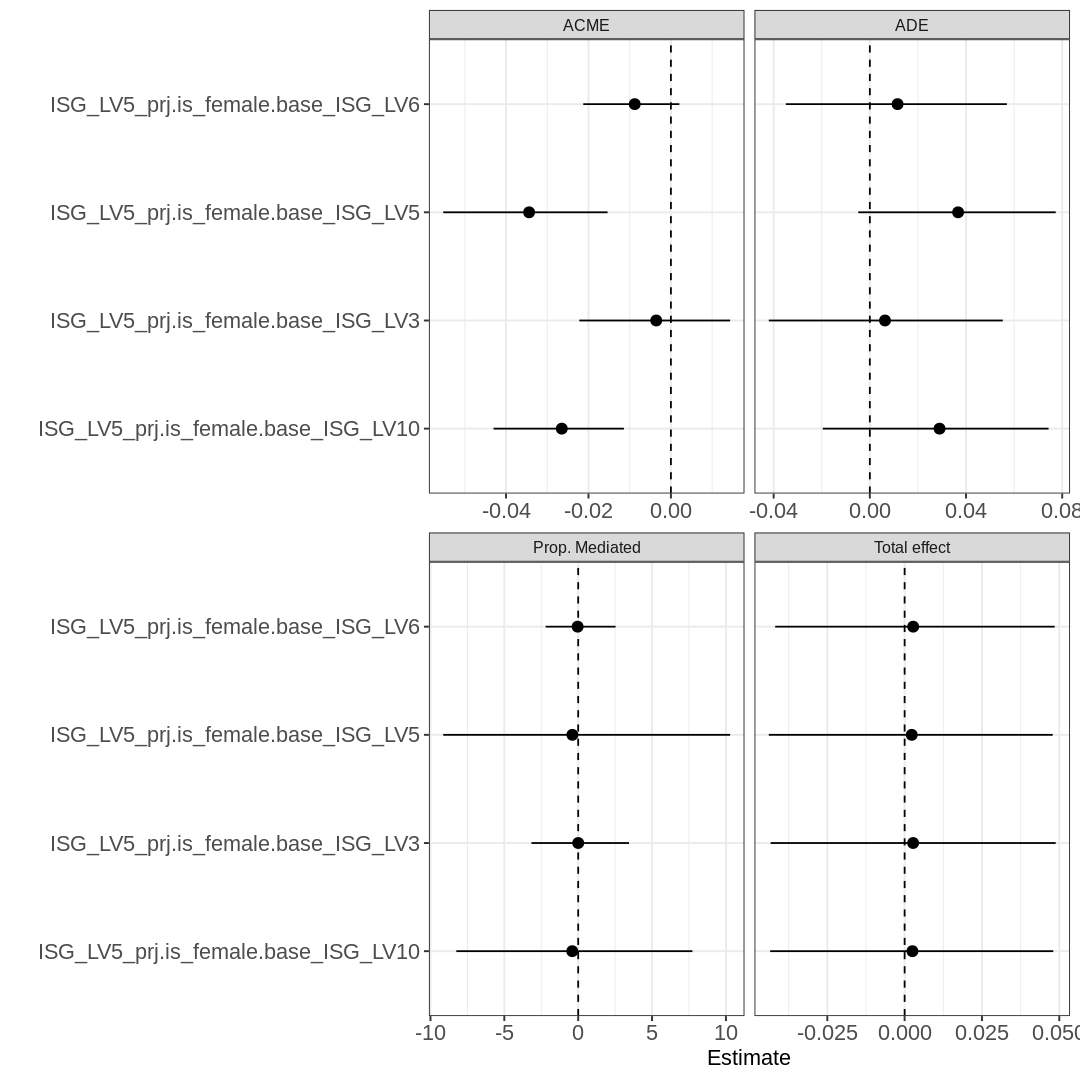

                                model         acme acme.p        prop prop.p
1  ISG_LV6_prj.is_female.base_ISG_LV3 -0.022668848  0.497 -0.09086639  0.497
2  ISG_LV6_prj.is_female.base_ISG_LV5 -0.003874044  0.785 -0.01373506  0.789
3  ISG_LV6_prj.is_female.base_ISG_LV6 -0.028045393  0.171 -0.10572424  0.173
4 ISG_LV6_prj.is_female.base_ISG_LV10 -0.031382510  0.255 -0.12354657  0.260


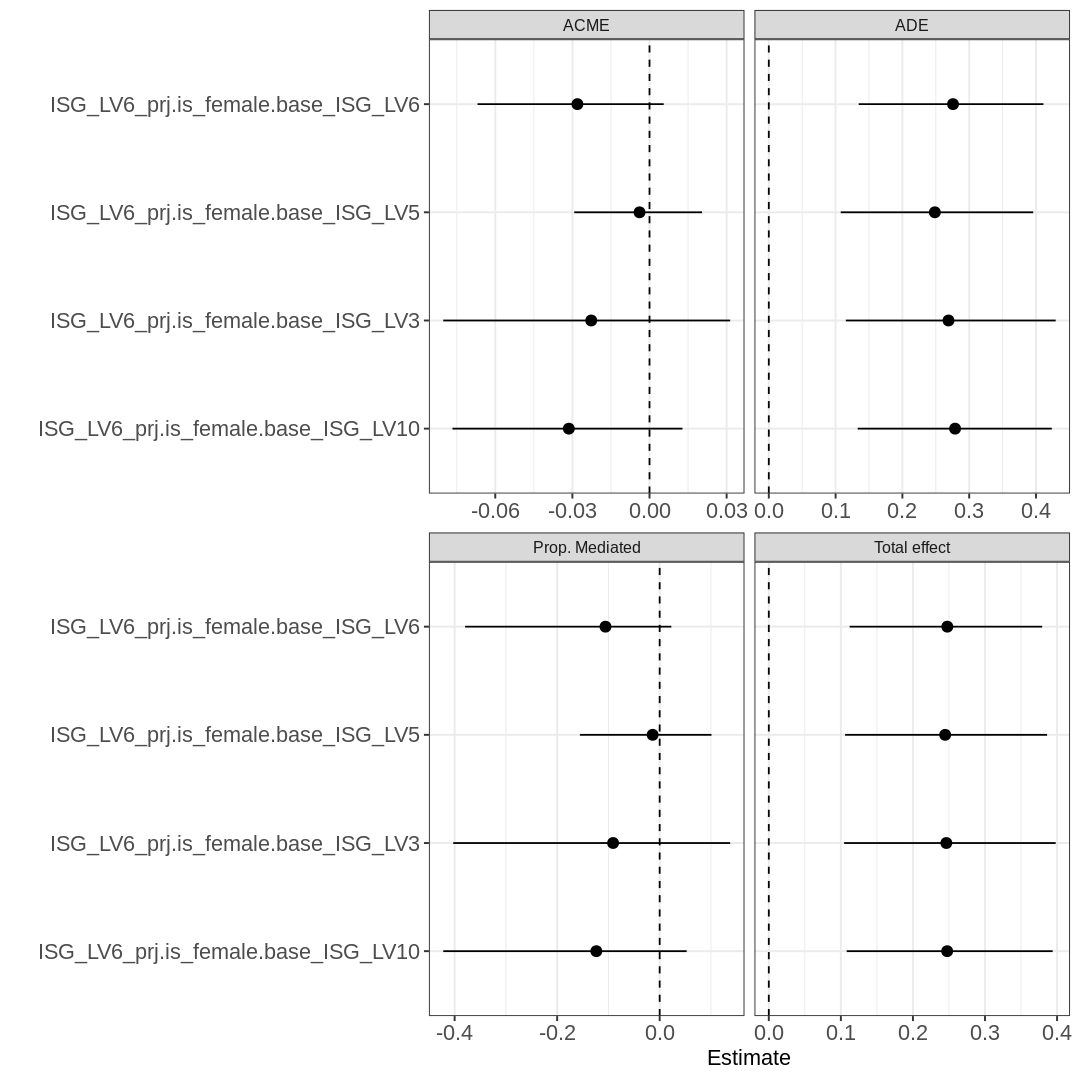

                                 model         acme acme.p        prop prop.p
1  ISG_LV10_prj.is_female.base_ISG_LV3 -0.009477511  0.740 -0.05067483  0.752
2  ISG_LV10_prj.is_female.base_ISG_LV5 -0.002167653  0.874 -0.01003328  0.871
3  ISG_LV10_prj.is_female.base_ISG_LV6 -0.039893110  0.046 -0.21844279  0.069
4 ISG_LV10_prj.is_female.base_ISG_LV10 -0.019214992  0.433 -0.10309726  0.443


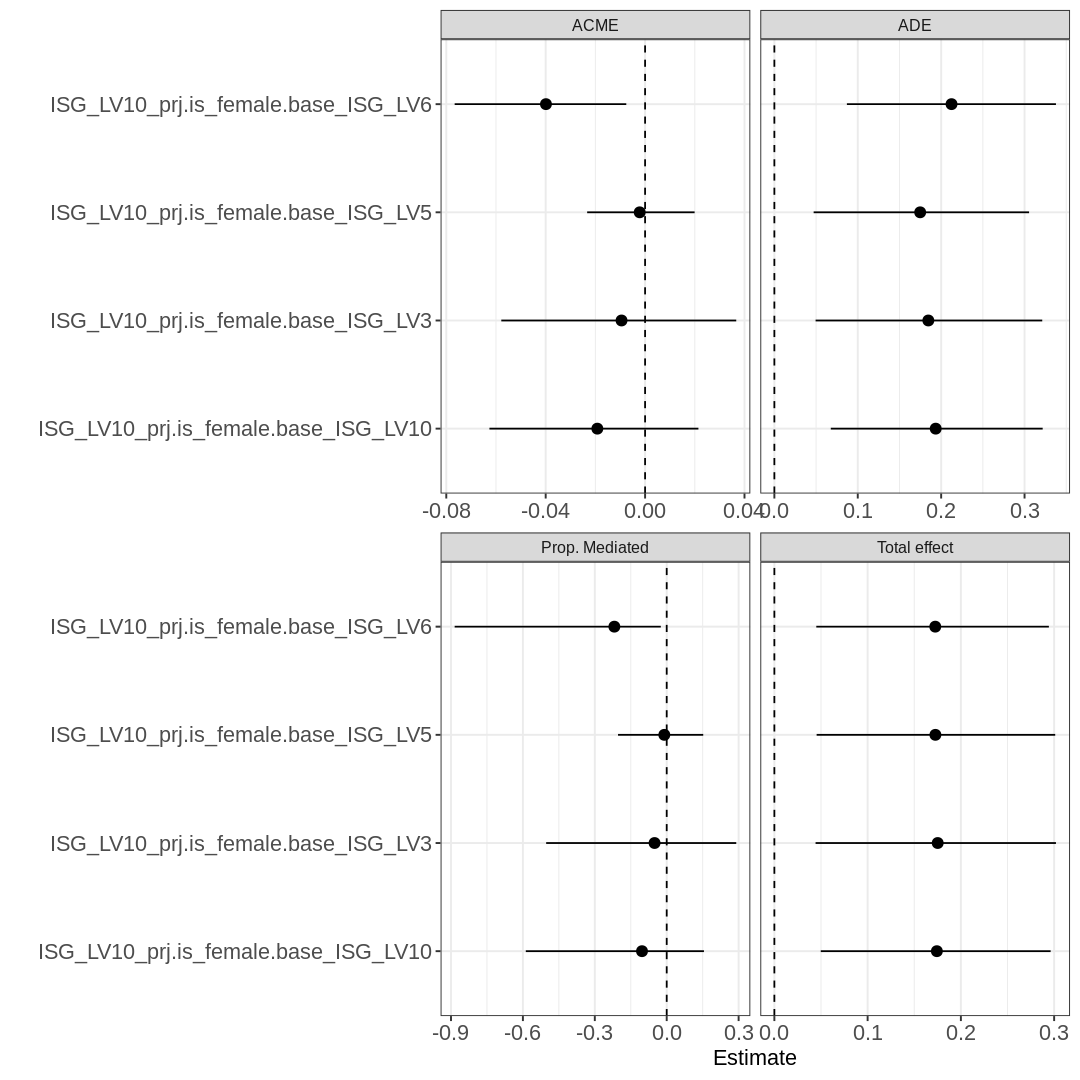

In [18]:
lmer_med_func2 = function(data, med_var, out_var, n_sim = N_SIMS, ...) { 
  if(length(grep('base_', med_var))) {
      # baseline ISG serves as a random intercept
      out_fit = lm(out_val ~ med_val + days_since_infect + is_female + Race + Ethnicity, data = data)
      med_fit = lm(med_val ~ is_female + days_since_infect + Race + Ethnicity, data = data)
  } else {
      out_fit = lmer(out_val ~ med_val + days_since_infect + is_female + (1|pid)+ Race + Ethnicity, data = data)
      med_fit = lmer(med_val ~ is_female + days_since_infect + (1|pid)+ Race + Ethnicity, data = data)
  }
  med_out = mediate(med_fit, out_fit, sims = n_sim,
                     treat = "is_female",
                     mediator = "med_val",
                     covariates = c('Race + Ethnicity'),
                     conf.level=0.9,
                     boots=T,
                     dropobs=T,
                     ...)
  tibble(mediator = paste(out_var, 'is_female', med_var, sep="."),
       effect = c("ACME", "ADE", "Total effect", "Prop. Mediated") ,
       estimate = c(med_out$d0, med_out$z0, med_out$tau.coef, med_out$n.avg),
       conf_lower = c(med_out$d0.ci[1], med_out$z0.ci[1], med_out$tau.ci[1], med_out$n.avg.ci[1]),
       conf_upper = c(med_out$d0.ci[2], med_out$z0.ci[2], med_out$tau.ci[2], med_out$n.avg.ci[2]),
       pvals = c(med_out$d0.p, med_out$z0.p, med_out$tau.p, med_out$n.avg.p)
    )
}

# ---------- #
set.seed(777)
this_mediators = c(#'viral_load', 
                   mediators # also add baseline ISG LVs
)
outcome = c('ISG_LV3_prj', 'ISG_LV5_prj', 'ISG_LV6_prj', 'ISG_LV10_prj')

for(i in 1:length(outcome)) {
    out_var = outcome[i]
    out_df = symp_df[!is.na(symp_df[,out_var]),]
    out_val = out_df[, out_var]
    lmer_med_res2 <- out_df %>%
      pivot_longer(all_of(this_mediators), names_to = "variable", values_to = "med_val") %>% 
      group_by(variable) %>% 
      nest() %>%
      mutate(results = map(data, lmer_med_func2, variable, n_sim = N_SIMS, out_var=out_var, out_val=out_val))

    g = lmer_med_res2 %>% select(-data) %>%
      unnest(c(results)) %>% 
      ggplot(aes(mediator, estimate, ymin = conf_lower, ymax = conf_upper)) + 
      facet_wrap(~ effect, scales = "free_x") + 
      geom_pointrange() + 
      coord_flip() + 
      labs(y = "Estimate", x = "") + 
      geom_hline(yintercept=0, linetype='dashed', color="black") + myTheme
    plot(g)
    
    tot_res = rbind.tibble.to_res(lmer_med_res2, tot_res)
}

# 4. Mediation for PSI.CD45 [BASELINE --> INFECT RNA-seq]

In [19]:
datasets = list(data=symp_df[!is.na(symp_df[,'delta_PSI_CD45RBC']),])

# pid=1344 had non-defined PSI
datasets$data %>% distinct(pid, Sex) %>% count(Sex)

Sex,n
<chr>,<int>
F,17
M,162


In [20]:
outcome = c('delta_PSI_CD45RBC')
treatment = c('is_female')
covariates = c('Race + Ethnicity')

set.seed(777)
x.psi = mediations(datasets, treatment, mediators, outcome,
        covariates=covariates,
        families=c('gaussian', 'gaussian'),
        conf.level=0.9,
        sims=N_SIMS
)

res.psi = NULL
for(i in 1:length(x.psi)) {
        this = summary(x.psi[[names(x.psi)[i]]])
        res.psi = rbind.data.frame(res.psi,
                list(
                        model = names(x.psi)[i],
                        acme = this$d.avg,
                        acme.p = this$d.avg.p,
                        prop = this$n0,
                        prop.p = this$n0.p
                ),
        stringsAsFactors=F
        )
}

#res.psi$acme.fdr = p.adjust(res.psi$acme.p, method='fdr')
print(res.psi[res.psi$acme.p<SIGNIF_CUTOFF,])
tot_res = rbind.data.frame(tot_res, res.psi[res.psi$acme.p<SIGNIF_CUTOFF,], stringsAsFactors=F)

                                      model         acme acme.p        prop
1  delta_PSI_CD45RBC.is_female.base_ISG_LV3  0.035701941  0.000  0.47491032
2  delta_PSI_CD45RBC.is_female.base_ISG_LV5 -0.008313921  0.007 -0.10214826
3  delta_PSI_CD45RBC.is_female.base_ISG_LV6  0.010368469  0.018  0.13217072
4 delta_PSI_CD45RBC.is_female.base_ISG_LV10 -0.001993907  0.769 -0.02574367
  prop.p
1  0.001
2  0.007
3  0.018
4  0.769


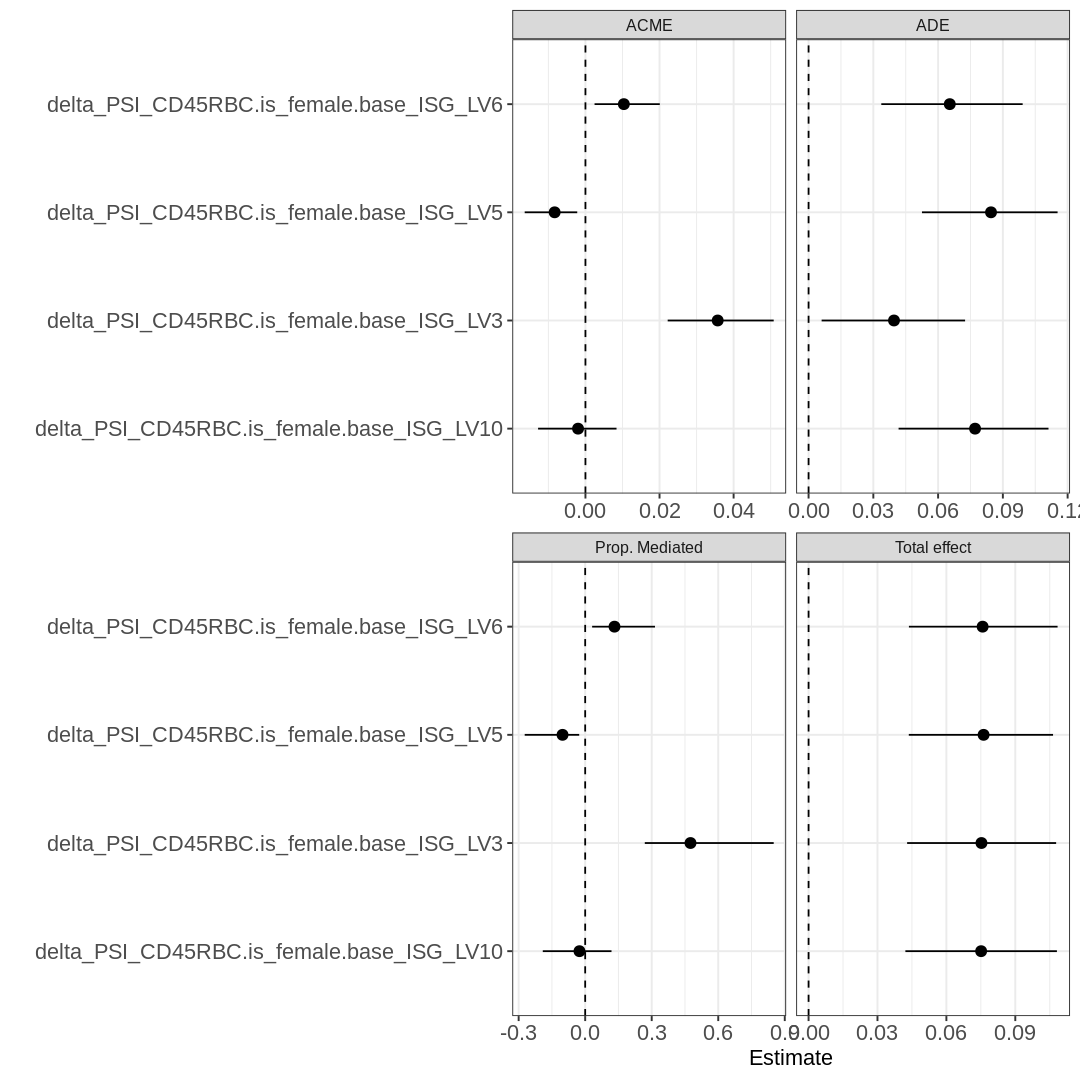

In [21]:
# vis results for cd45
this = res.psi[res.psi$acme.p<SIGNIF_CUTOFF,]
if(nrow(this)>0) vis_med_out(res.psi, x.psi)

# 5. Number of Symptoms over Time mediated by Infection ISGs [INFECT -> INFECT RNA-seq]

In [22]:
datasets = list(data=symp_df[!is.na(symp_df[,'ISG_LV3_prj']),])

datasets$data %>% distinct(pid, Sex) %>% count(Sex)

Sex,n
<chr>,<int>
F,34
M,188


                                      model        acme acme.p        prop
1  Num_Symps_overTime.is_female.ISG_LV3_prj  0.03460983  0.094  0.03661439
2  Num_Symps_overTime.is_female.ISG_LV5_prj -0.02144959  0.248 -0.01996986
3  Num_Symps_overTime.is_female.ISG_LV6_prj  0.13057387  0.000  0.14299004
4 Num_Symps_overTime.is_female.ISG_LV10_prj  0.15686824  0.000  0.17195071
  prop.p
1  0.094
2  0.248
3  0.000
4  0.000


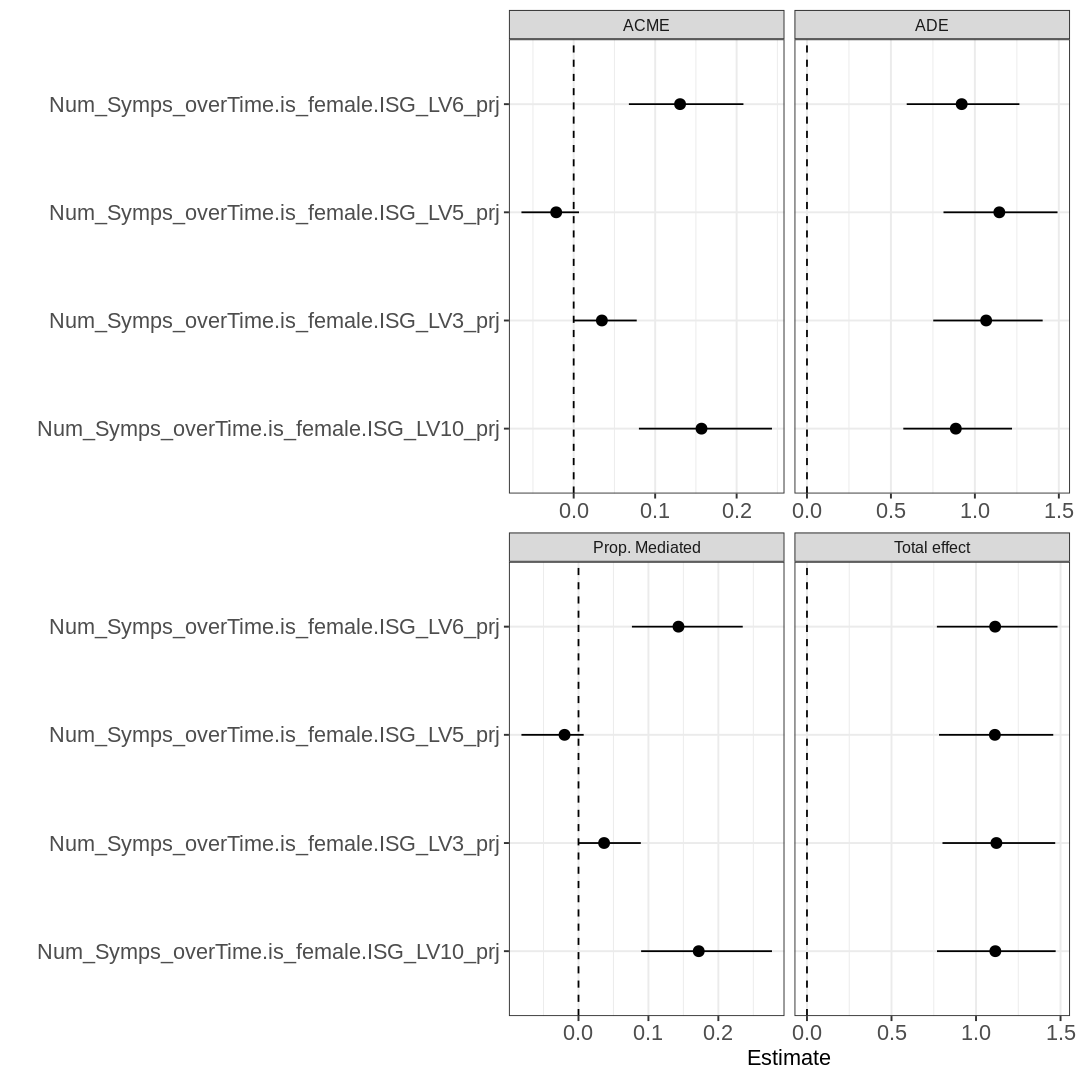

In [23]:
poisson_med_func2 <- function(data, med_var, n_sim = N_SIMS, ...) { 
  #out_fit <- glmer(num_symps ~ value + days_since_infect + is_female + (1|pid), data = data, family='poisson')
  out_fit <- glm(num_symps ~ value + days_since_infect + is_female  + Race_White + Race_Black + Race_Asian + Race_Multi_racial + Ethnicity_Hispanic, data = data, family='poisson')
  med_fit <- lmer(value ~ days_since_infect + is_female + (1|pid) + Race_White + Race_Black + Race_Asian + Race_Multi_racial + Ethnicity_Hispanic, data = data)
  med_out <- mediate(med_fit, out_fit, sims = n_sim,
                     treat = "is_female",
                     mediator = "value",
                     covariates = c('Race_White + Race_Black + Race_Asian + Race_Multi_racial + Ethnicity_Hispanic'),
                     conf.level=0.9,
                     boots=F,
                     ...)
  tibble(mediator = paste('Num_Symps_overTime', 'is_female', med_var, sep="."),
       effect = c("ACME", "ADE", "Total effect", "Prop. Mediated") ,
       estimate = c(med_out$d0, med_out$z0, med_out$tau.coef, med_out$n.avg),
       conf_lower = c(med_out$d0.ci[1], med_out$z0.ci[1], med_out$tau.ci[1], med_out$n.avg.ci[1]),
       conf_upper = c(med_out$d0.ci[2], med_out$z0.ci[2], med_out$tau.ci[2], med_out$n.avg.ci[2]),
       pvals = c(med_out$d0.p, med_out$z0.p, med_out$tau.p, med_out$n.avg.p)
    )
}

# ---------- #
set.seed(111)
this_mediators = c('ISG_LV3_prj', 'ISG_LV5_prj', 'ISG_LV6_prj', 'ISG_LV10_prj')
pois_med_res2 <- symp_df %>%
  pivot_longer(all_of(this_mediators), names_to = "variable", values_to = "value") %>% 
  group_by(variable) %>% 
  nest() %>%
  mutate(results = map(data, poisson_med_func2, variable, n_sim = N_SIMS))

pois_med_res2 %>% select(-data) %>%
  unnest(c(results)) %>% 
  ggplot(aes(mediator, estimate, ymin = conf_lower, ymax = conf_upper)) + 
  facet_wrap(~ effect, scales = "free_x") + 
  geom_pointrange() + 
  coord_flip() + 
  labs(y = "Estimate", x = "") + 
  geom_hline(yintercept=0, linetype='dashed', color="black") + myTheme

tot_res = rbind.tibble.to_res(pois_med_res2, tot_res)

# Summary

In [24]:
tot_res$acme.fdr = p.adjust(tot_res$acme.p, method='fdr')
tot_res[order(tot_res$acme.fdr),]

,model,acme,acme.p,prop,prop.p,acme.fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,Num_Symps.is_female.base_ISG_LV3,-0.403703682,0.000,-0.858450547,0.038,0.000000000
9,ISG_LV3_prj.is_female.base_ISG_LV3,0.120623568,0.000,0.651736886,0.010,0.000000000
25,delta_PSI_CD45RBC.is_female.base_ISG_LV3,0.035701941,0.000,0.474910325,0.001,0.000000000
31,Num_Symps_overTime.is_female.ISG_LV6_prj,0.130573870,0.000,0.142990040,0.000,0.000000000
32,Num_Symps_overTime.is_female.ISG_LV10_prj,0.156868243,0.000,0.171950709,0.000,0.000000000
14,ISG_LV5_prj.is_female.base_ISG_LV5,-0.034403763,0.001,-0.392893874,0.925,0.004571429
16,ISG_LV5_prj.is_female.base_ISG_LV10,-0.026475070,0.001,-0.401595391,0.911,0.004571429
26,delta_PSI_CD45RBC.is_female.base_ISG_LV5,-0.008313921,0.007,-0.102148259,0.007,0.028000000
27,delta_PSI_CD45RBC.is_female.base_ISG_LV6,0.010368469,0.018,0.132170721,0.018,0.064000000


In [25]:
write.table(tot_res, file="./data/mediation_analysis/out.cma.txt", quote=F, row.names=F, sep="\t")